In [1]:
%matplotlib inline

import glob
import os
import random
import json

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from rubin_sim.utils import getPackageDir
#from rubin_sim.maf import KN_lc, KNePopMetric, generateKNPopSlicer, get_filename
from kneMetrics import KN_lc, KNePopMetric, generateKNPopSlicer, get_filename
import healpy as hp

In [15]:


class TransientMetric:
    def __init__(self, transient_name, transient_params, max_distance, light_curve_model, weights=None):
        """
        Initialize the metric for a transient.

        Parameters:
        - transient_name: str, name of the transient (e.g., 'Kilonovae')
        - transient_params: dict, library of transient parameters
        - max_distance: float, maximum distance for valid detections
        - light_curve_model: callable, function to generate synthetic light curves
        - weights: dict, weights for combining metrics in aggregation
        """
        self.transient_name = transient_name
        self.params = transient_params[transient_name]
        self.max_distance = max_distance
        self.light_curve_model = light_curve_model
        self.weights = weights or {}

    def generate_light_curve(self, times, filter_name):
        """Generate a synthetic light curve for a specific filter using the model."""
        return self.light_curve_model(
            times,
            rise_rate=np.random.uniform(*self.params["riseRates"][filter_name]),
            fade_rate=np.random.uniform(*self.params["fadeRates"][filter_name]),
            peak_mag=np.random.uniform(*self.params["peakMagRange"][filter_name]),
            peak_duration=self.params["durationAtPeak"][filter_name]
        )

    def detect_initial_peak(self, times, mags):
        """Identify the initial peak in the light curve."""
        peak_index = np.argmax(-mags)  # Magnitudes are negative-log, so lower is brighter
        return times[peak_index], mags[peak_index]

    def apply_distance_cut(self, distances):
        """Exclude events beyond the maximum distance."""
        return distances[distances <= self.max_distance]

    def calculate_detection_rate(self, distances, times, mags):
        """
        Calculate the detection rate based on the provided criteria.
        
        Parameters:
        - distances: array-like, distances of transient events
        - times: array-like, times of observations
        - mags: array-like, magnitudes of light curves

        Returns:
        - Detection rate as a fraction.
        """
        valid_distances = self.apply_distance_cut(distances)
        detections = 0

        for dist in valid_distances:
            if np.any(mags < self.params.get("detection_threshold", 24.5)):
                detections += 1

        return detections / len(valid_distances) if len(valid_distances) > 0 else 0

    def evaluate_metric(self, times, distances, filter_name):
        """
        Evaluate the metric based on synthetic light curve simulations.

        Parameters:
        - times: array-like, times of observations
        - distances: array-like, distances of transient events
        - filter_name: str, filter to simulate ('u', 'g', 'r', 'i', 'z', 'y')

        Returns:
        - Detection rate.
        """
        mags = self.generate_light_curve(times, filter_name)
        detection_rate = self.calculate_detection_rate(distances, times, mags)
        return detection_rate

    def plot_light_curve(self, times, mags, filter_name):
        """Visualize the light curve for a specific filter."""
        plt.figure()
        plt.plot(times, mags, label=f"{self.transient_name} Light Curve ({filter_name})")
        plt.gca().invert_yaxis()  # Bright magnitudes are lower
        plt.xlabel("Time (days)")
        plt.ylabel("Magnitude")
        plt.title(f"Light Curve for {self.transient_name} ({filter_name})")
        plt.legend()
        plt.show()

# Define a synthetic light curve model
def synthetic_light_curve(t, rise_rate, fade_rate, peak_mag, peak_duration):
    """
    Generate a simple synthetic light curve.
    
    Parameters:
    - t: array-like, times
    - rise_rate: float, rise rate in mag/day
    - fade_rate: float, fade rate in mag/day
    - peak_mag: float, peak magnitude
    - peak_duration: float, duration at peak
    
    Returns:
    - Magnitudes at each time step.
    """
    t_peak = t[np.argmin(np.abs(t - peak_duration))]
    rise = peak_mag - rise_rate * (t[t <= t_peak] - t[t <= t_peak][0])
    fade = peak_mag + fade_rate * (t[t > t_peak] - t_peak)
    return np.concatenate((rise, fade))

Detection Rate for Kilonovae (r filter): 100.00%


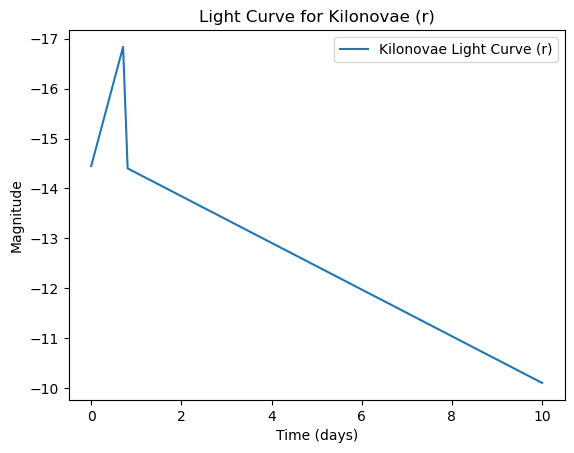

In [19]:
### Example usage:
if __name__ == "__main__":
    times = np.linspace(0, 10, 100)
    distances = np.random.uniform(10, 500, 1000)  # Distances in Mpc

    # Initialize the transient parameter library
    transient_params = {
    "Kilonovae": {
        "riseRates": {'u': (0.25, 4.75), 'g': (0.25, 4.75), 'r': (0.5, 4.75), 
                      'i': (0.5, 4.75), 'z': (0.5, 4.5), 'y': (0.25, 4.75)},
        "fadeRates": {'u': (0.5, 1.8), 'g': (0.5, 1.6), 'r': (0.4, 1.2), 
                      'i': (0.3, 0.9), 'z': (0.2, 0.8), 'y': (0.2, 0.7)},
        "peakMagRange": {'u': (-15.5, -13.5), 'g': (-15.5, -14), 'r': (-15.5, -13), 
                         'i': (-16, -13), 'z': (-16, -13.5), 'y': (-16.5, -13.5)},
        "durationAtPeak": {'u': 0.1, 'g': 0.3, 'r': 0.7, 'i': 1, 'z': 1.5, 'y': 2}
    },
    "GRB": {
        "riseRates": {'u': (6, 160), 'g': (6, 160), 'r': (6, 160),
                      'i': (6, 160), 'z': (6, 160), 'y': (6, 160)},
        "fadeRates": {'u': (0.1, 10), 'g': (0.1, 10), 'r': (0.1, 10), 
                      'i': (0.1, 10), 'z': (0.1, 10), 'y': (0.1, 10)},
        "peakMagRange": {'u': (-24, -22), 'g': (-24, -22), 'r': (-24, -22), 
                         'i': (-24, -22), 'z': (-24, -22), 'y': (-24, -22)},
        "durationAtPeak": {'u': 0.1, 'g': 0.1, 'r': 0.1, 'i': 0.1, 'z': 0.1, 'y': 0.1}
    },
    "SCE": {
        "riseRates": {'u': "-", 'g': (1.09, 0.34), 'r': (0.97, 0.35), 
                      'i': "-", 'z': "-", 'y': "-"},
        "fadeRates": {'u': "-", 'g': (0.23, 0.087), 'r': (0.18, 0.095), 
                      'i': "-", 'z': "-", 'y': "-"},
        "peakMagRange": {'u': "-", 'g': (-14.82, -18.65), 'r': (-14.82, -18.21), 
                         'i': "-", 'z': "-", 'y': "-"},
        "durationAtPeak": {'u': "-", 'g': "~2.35", 'r': "~2.90", 
                           'i': "-", 'z': "-", 'y': "-"}
    },
    "M Dwarf": {
        "riseRates": {'u': (0.027, 6.38), 'g': (0.009, 3.89), 'r': (0.005, 2.15), 
                      'i': (0.0027, 0.415), 'z': (0.002, 0.113), 'y': (0.0014, 0.051)},
        "fadeRates": {'u': (0.019, 1.30), 'g': (0.006, 0.79), 'r': (0.003, 0.44), 
                      'i': (0.0019, 0.085), 'z': (0.001, 0.023), 'y': (0.001, 0.01)},
        "peakMagRange": {'u': "-", 'g': (14.05, 16.44), 'r': (14.01, 15.99), 
                         'i': (12.90, 15.21), 'z': (12.13, 14.06), 'y': (11.68, 13.18)},
        "durationAtPeak": {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
    },
    "LFBOT": {
        "riseRates": {'u': "-", 'g': (0.25, 2.5), 'r': (0.25, 2.5), 
                      'i': "-", 'z': "-", 'y': "-"},
        "fadeRates": {'u': "-", 'g': (0.15, 0.45), 'r': (0.15, 0.45), 
                      'i': "-", 'z': "-", 'y': "-"},
        "peakMagRange": {'u': "-", 'g': (-21.5, -20), 'r': (-21.5, -20), 
                         'i': "-", 'z': "-", 'y': "-"},
        "durationAtPeak": {'u': "-", 'g': "< 4", 'r': "< 4", 
                           'i': "-", 'z': "-", 'y': "-"},
        "timeAboveHalfMax": {'u': "-", 'g': 12, 'r': 12, 
                             'i': "-", 'z': "-", 'y': "-"}
    },
    "YSO": {
        "riseRates": {'u': (0.005, 1.5), 'g': "-", 'r': (0.001, 0.6), 
                      'i': "-", 'z': "-", 'y': "-"},
        "fadeRates": {'u': (0.02, 0.5), 'g': "-", 'r': (0.02, 0.3), 
                      'i': "-", 'z': "-", 'y': "-"},
        "peakMagRange": {'u': "-", 'g': "-", 'r': "-", 
                         'i': "-", 'z': "-", 'y': "-"},
        "durationAtPeak": {'u': (0.15, 5), 'g': "-", 'r': (0.15, 5), 
                           'i': "-", 'z': "-", 'y': "-"}
    },
    "SNe Ib-n": {
        "riseRates": {'u': (0.05, None), 'g': (0.14, 0.03), 'r': (0.11, 0.08), 
                      'i': (0.04, 0.02), 'z': "-", 'y': "-"},
        "fadeRates": {'u': (0.12, None), 'g': (0.12, 0.01), 'r': (0.13, 0.01), 
                      'i': (0.12, 0.03), 'z': "-", 'y': "-"},
        "peakMagRange": {'u': (18.29, None), 'g': (17.18, 18.84), 'r': (14.36, 18.95), 
                         'i': (14.37, 19.14), 'z': "-", 'y': "-"},
        "durationAtPeak": {'u': (3.4, None), 'g': (2.3, 0.85), 'r': (3.17, 1.03), 
                           'i': (3.0, 0.82), 'z': "-", 'y': "-"}
    },
    "SNe Ic-n": {
        "riseRates": {
            'u': (0.08, 0.28), 'g': (0.19, 0.35), 'r': (0.10, 0.38),
            'i': (0.11, 0.31), 'z': (0.08, 0.18), 'y': "-"
        },
        "fadeRates": {
            'u': (0.11, 0.21), 'g': (0.08, 0.20), 'r': (0.10, 0.30),
            'i': (0.09, 0.19), 'z': (0.05, 0.25), 'y': "-"
        },
        "peakMagRange": {
            'u': (-18.5, -20), 'g': (-17, -20), 'r': (-17, -19.5),
            'i': (-17, -19), 'z': (-18, -19), 'y': "-"
        },
        "durationAtPeak": {
            'u': (3.5, 4.5), 'g': (3.2, 6.0), 'r': (2.5, 4.9),
            'i': (3.6, 6.4), 'z': (4.3, 5.7), 'y': "-"
        }
    }
}



Evaluating Kilonovae
Detection Rate for Kilonovae (r filter): 100.00%


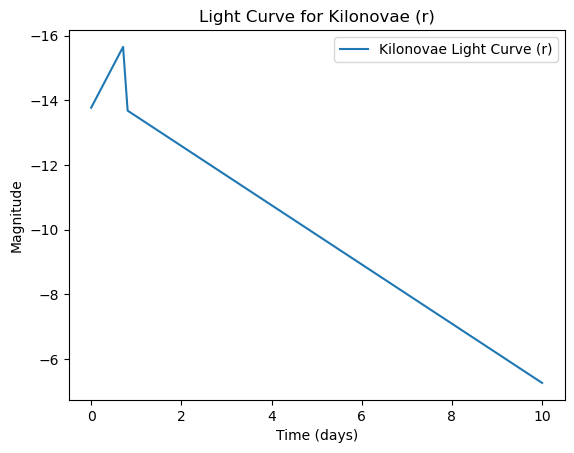

Evaluating GRB
Detection Rate for GRB (r filter): 100.00%


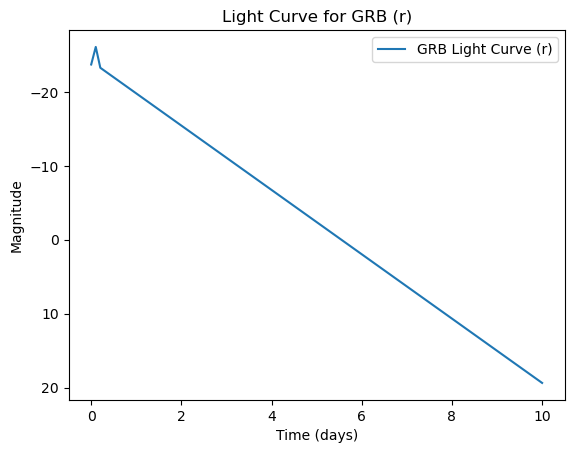

In [26]:
if __name__ == "__main__":
    # Generate synthetic observation times and distances
    times = np.linspace(0, 10, 100)  # Time grid (days)
    distances = np.random.uniform(10, 500, 1000)  # Distances in Mpc

    # Initialize the transient parameter library
    transient_params = {
        "Kilonovae": {
            "riseRates": {'u': (0.25, 4.75), 'g': (0.25, 4.75), 'r': (0.5, 4.75), 
                          'i': (0.5, 4.75), 'z': (0.5, 4.5), 'y': (0.25, 4.75)},
            "fadeRates": {'u': (0.5, 1.8), 'g': (0.5, 1.6), 'r': (0.4, 1.2), 
                          'i': (0.3, 0.9), 'z': (0.2, 0.8), 'y': (0.2, 0.7)},
            "peakMagRange": {'u': (-15.5, -13.5), 'g': (-15.5, -14), 'r': (-15.5, -13), 
                             'i': (-16, -13), 'z': (-16, -13.5), 'y': (-16.5, -13.5)},
            "durationAtPeak": {'u': 0.1, 'g': 0.3, 'r': 0.7, 'i': 1, 'z': 1.5, 'y': 2}
        },
        "GRB": {
            "riseRates": {'u': (6, 160), 'g': (6, 160), 'r': (6, 160), 
                          'i': (6, 160), 'z': (6, 160), 'y': (6, 160)},
            "fadeRates": {'u': (0.1, 10), 'g': (0.1, 10), 'r': (0.1, 10), 
                          'i': (0.1, 10), 'z': (0.1, 10), 'y': (0.1, 10)},
            "peakMagRange": {'u': (-24, -22), 'g': (-24, -22), 'r': (-24, -22), 
                             'i': (-24, -22), 'z': (-24, -22), 'y': (-24, -22)},
            "durationAtPeak": {'u': 0.1, 'g': 0.1, 'r': 0.1, 'i': 0.1, 'z': 0.1, 'y': 0.1}
        }
    }

    # List of transients to evaluate
    transient_names = ["Kilonovae", "GRB"]

    # Initialize metrics for all transients
    metrics = []
    for transient_name in transient_names:
        metric = TransientMetric(
            transient_name=transient_name,
            transient_params=transient_params,
            max_distance=300,  # Mpc
            light_curve_model=synthetic_light_curve
        )
        metrics.append(metric)

    # Evaluate and plot results for each transient in the 'r' filter
    for metric in metrics:
        print(f"Evaluating {metric.transient_name}")
        mags = metric.generate_light_curve(times, "r")
        detection_rate = metric.evaluate_metric(times, distances, "r")
        print(f"Detection Rate for {metric.transient_name} (r filter): {detection_rate:.2%}")
        metric.plot_light_curve(times, mags, "r")